# PK Modelling Project - Mirtazapine

1 - [Sample Data Generation](#part1)  
2 - [Setting up Differential Equations](#part2)    
3 - [Solving ODE with Optimization](#part3)  
4 - [Generation of Plasma Concentration Trajectory Data with Python](#part4)  
5 - [Final Optimization](#part5)

In [221]:
# Import basic dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import time
import pickle

# Import local scikit-pk (skpk) library - https://stackoverflow.com/questions/67631/how-to-import-a-module-given-the-full-path
import sys
sys.path.append(r'C:\Users\klty0\Desktop\scikit-pk\src')
# sys.path.append(r'C:\Users\Kenneth Leung\Desktop\scikit-pk\src')

import skpk

# Import ODE modules
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import differential_evolution

In [ ]:
# Data Preparation

<a name="part1"></a>
## 1 - Sample Data Generation from Raw Data  

##### 1.1 - Data from R linpk package

In [3]:
# Import all trajectory raw data csv files into a list
list_of_trajectory_data = []

path = "./Raw/*.csv"
for fname in glob.glob(path):
    raw_df = pd.read_csv(fname)
    list_of_trajectory_data.append(raw_df)

In [4]:
# Number of raw datasets in list
len(list_of_trajectory_data)

17

In [5]:
# View raw df from list
list_of_trajectory_data[2]

,time,conc
0,0.000000,0.000000
1,0.033349,0.001587
2,0.066698,0.003113
3,0.100046,0.004582
4,0.133395,0.005993
...,...,...
2155,71.866605,0.000013
2156,71.899954,0.000013
2157,71.933302,0.000013
2158,71.966651,0.000013


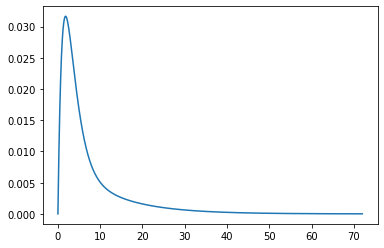

In [6]:
# Sample trajectory
plt.plot(list_of_trajectory_data[2].time, list_of_trajectory_data[2].conc)

In [7]:
# Round values of time column to 2 decimal place for every dataframe in list, and also
# Convert concentration from ug/mL to ug/L (as per units used in literature) by multiplying by 1000 
for raw_df in list_of_trajectory_data:
    raw_df['time'] = raw_df['time'].round(decimals = 2)
    raw_df['conc'] = raw_df['conc'] * 1000

In [8]:
list_of_trajectory_data[2].sample(7)

,time,conc
546,18.21,1.889399
1126,37.55,0.312770
338,11.27,4.123707
670,22.34,1.280018
3,0.10,4.581639
1396,46.55,0.135883
1819,60.66,0.036808


In [9]:
# List of timepoints
# pd.set_option('display.max_row', 1200)
list_of_trajectory_data[2].time.head()

0    0.00
1    0.03
2    0.07
3    0.10
4    0.13
Name: time, dtype: float64

___
Time points used in [25] Pharmacokinetics of mirtazapine from orally administered tablets - influence of gender, age and treatment regimen (Hum Psychopharmacol 1996): **[0, 0.25, 0.50, 0.75, 1.00, 1.25, 1.75, 2.00, 3.00, 4.00, 6.00, 8.00, 11.00, 15.00, 24.00, 48.00, 72.00, 96.00, 120.00]**

Time points to use to generate samples:
**[0, 0.23, 0.50, 0.77, 1.00, 1.23, 1.77, 2.00, 3.00, 4.00, 6.00, 8.00, 11.01, 15.01, 24.01, 48.02, 72.00]**

In [10]:
sampling_timepoints = [0.00, 0.23, 0.50, 0.77, 1.00, 1.23, 1.77, 2.00, 3.00, 4.00, 6.00, 8.00, 11.01, 15.01, 24.01, 48.02, 72.00]

In [11]:
list_of_samples_R = []

for raw_df in list_of_trajectory_data:
    sample_df = raw_df.loc[raw_df['time'].isin(sampling_timepoints)]
    sample_df.reset_index(drop=True, inplace=True)
    list_of_samples_R.append(sample_df)

In [12]:
# Sample data of Subject 05
list_of_samples_R[4]

,time,conc
0,0.00,0.000000
1,0.23,15.699323
2,0.50,27.580222
3,0.77,34.774528
4,1.00,38.321612
5,1.23,40.035575
6,1.77,39.664269
7,2.00,38.407975
8,3.00,30.697208
9,4.00,23.503854


In [13]:
# Create list of file numbers for naming of exported csv files
file_numbers = range(1,len(list_of_samples_R)+1)
file_numbers

range(1, 18)

In [14]:
# Export files as csv into Samples folder
for file_number, sample_df in zip(file_numbers,list_of_samples_R):
    if file_number < 10:
        file_name = f'subject0{file_number}_sample.csv'
        sample_df.to_csv(f'.\Samples\{file_name}',  index=False)
    else:
        file_name = f'subject{file_number}_sample.csv'
        sample_df.to_csv(f'.\Samples\{file_name}',  index=False)

___

<a name="part2"></a>
## 2 - Setting Up Differential Equations

Develop differential equations for a two-compartmental model (central compartment and peripheral compartment) for Mirtazapine.  

C0 is the additional term involving drug absorption into the central compartment for oral route, where C0(t=0) = Dose * Bioavailability (F).   
If IV route, can assign the term $k_a C_0(t)$ as 0.  

For this experiment, to start with oral administration first

Reference: https://sites.ualberta.ca/~csps/JPPS2(3)/F.Khorasheh/Application-Khorasheh.pdf  


$\frac{dC_0(t)}{dt} = -k_a C_0(t)$

$\frac{dC_1(t)}{dt} = k_a C_0(t) - (k_{12} + k_e) C_1(t) + k_{21} C_2(t) $

$\frac{dC_2(t)}{dt} = k_{12} C_1(t) - k_{21} C_2(t)$

We express the ODE problem with the following equation  

$\frac{dC}{dt} = \textbf{A}*\textbf{C} $

where $\frac{dC}{dt}$ is a $n x 1$ matrix, $\textbf{A}$ is a $n x n$ matrix, and $\textbf{C}$ is a $n x 1$ matrix (where n = number of compartments)

**C0** = Initial drug concentration (GI tract compartment not considered part of two-compartment model)  
**C1** = Drug concentration in Central Compartment (1)  
**C2** = Drug concentration in Peripheral Compartment (2)  
**ka** = Absorption rate constant  
**k12** = Distribution rate constant from Compartment 1 (Central) to 2 (Peripheral)  
**k21** = Distribution rate constant from Compartment 2 (Peripheral) to 1 (Central)  
**ke** = Elimination rate constant

In [19]:
# Instantiate the 3 relevant compartment instances of the 2-compartment model
C0 = skpk.Cmt(0, 'Absorption (GI Tract)')
C1 = skpk.Cmt(1, 'Central')
C2 = skpk.Cmt(2, 'Peripheral')
C3 = skpk.Cmt(3, 'External / Elimination')

0-Absorption (GI Tract) compartment successfully generated
1-Central compartment successfully generated
2-Peripheral compartment successfully generated
3-External / Elimination compartment successfully generated


In [1]:
# Instantiate a PK model instance
pk_model = skpk.Model('PK Model - Mirtazapine')

NameError: name 'skpk' is not defined

In [21]:
# Initializing k values
ka, k12, k21, ke = [1,2,3,4]

In [22]:
# Adding compartment instances to model instance
pk_model.add_cmt([C0, C1, C2, C3])

In [23]:
# Adding links between the compartments
pk_model.add_link([(C0, C1, ka), (C1, C2, k12), (C2, C1, k21), (C1, C3, ke)])

In [24]:
pk_model.summary()


Name of Model Instance = PK Model - Mirtazapine
Number of Compartments = 4
Number of Links = 4

======================= Compartment Attributes =======================
CMT ID               | CMT Name               | CMT Volume (L)          
----------------------------------------------------------------------
0                    | Absorption (GI Tract)  | 0                       
1                    | Central                | 0                       
2                    | Peripheral             | 0                       
3                    | External / Elimination | 0                       

============================= Link Attributes =============================
From CMT (ID - Name)          |To CMT (ID - Name)            |k rate constant               
---------------------------------------------------------------------------
0 - Absorption (GI Tract)     |1 - Central                   |1                        
1 - Central                   |2 - Peripheral                |

In [25]:
# Checking array of existing link tuples
pk_model.list_cmt_link_tuples

[(0, 'Absorption (GI Tract)', 0, 1, 'Central', 0, 1),
 (1, 'Central', 0, 2, 'Peripheral', 0, 2),
 (2, 'Peripheral', 0, 1, 'Central', 0, 3),
 (1, 'Central', 0, 3, 'External / Elimination', 0, 4)]

In [26]:
# Number of compartments (+1 for GI tract compartment in oral administration)
n = 2 + 1

In [27]:
full_matrix = pk_model.get_matrix()

In [28]:
# Ignore last elimination compartment (C3), so we truncate matrix size by 1 (from 4 to 3) to form coefficient matrix
A_matrix = full_matrix[0:n,0:n]
print(A_matrix)

[[-1.  0.  0.]
 [ 1. -6.  3.]
 [ 0.  2. -3.]]


In [29]:
# Start time (h) of trajectory
period_start = 0

# End time (h) of trajectory
period_end = 72

# Number of intervals across time horizon
intervals = 2160

# Bioavailability for Mirtazapine (i.e. 49.7%)
F = 0.497 

# Mirtazapine dose (in mg)
dose = 15

In [30]:
# np.set_printoptions(threshold=sys.maxsize) # Display all values in array
np.set_printoptions(suppress=True) # Suppress scientific format of the numbers in array (display float as general numerical format)

In [31]:
# Creating intervals across the time horizon of 72 hours
time_horizon = np.around(np.linspace(period_start, period_end, intervals),decimals=2)
time_horizon

array([ 0.  ,  0.03,  0.07, ..., 71.93, 71.97, 72.  ])

In [32]:
# Create array for concentration vector
C_initial = np.zeros(shape=(1,n))

# Initial dose C0 (1st element of vector) = Dose x Bioavailability
C_initial[0,0] = dose * F

# Show C_initial vector (C0(t=0), C1(t=0), C2(t=0))
C_initial 

array([[7.455, 0.   , 0.   ]])

In [33]:
# Reshape C_initial into 1 dimension to pass into solve_ivp (since initial condition y0 must be 1-dimensional for solve_ivp)
C_initial_1dim = C_initial.reshape(n,)

In [34]:
# Define dcdt function of ODE (dot multiplication of coefficient matrix and concentration)
def dC(t,C,A):
   
    # Dot multiplication of A coefficient matrix (n x n) with concentration vector C (n x 1) 
    dCdt = np.dot(A, C)
    
    # Returns dCdt as n x 1 vector (dC0/dt, dC1/dt, dC2/dt)
    return dCdt

___

In [35]:
# Run solve_ivp algorithm
C_output = solve_ivp(fun=dC, t_span=[period_start, period_end], y0 = C_initial_1dim, t_eval = time_horizon, args=(A_matrix,))

In [36]:
C_output.y[1]

array([ 0.        ,  0.20172744,  0.41248234, ..., -0.00000051,
       -0.00000064, -0.00000058])

In [37]:
len(C_output.y[0])

2160

___
<a name="part3"></a>
## 3 - Solving ODE with Optimization

##### 3.1 - Using Manually Generated Sample Data with R linpk Package

In [38]:
# Pre-defined parameters
F = 0.497 # Bioavailability
n = 3 # Number of compartments (+1 for GI tract compartment for oral route)

period_start = 0
period_end = 72
intervals = 2160
time_horizon = np.around(np.linspace(period_start, period_end, intervals), decimals=2)

In [39]:
# Generate compartments and model instances to create coefficient matrix
C0 = skpk.Cmt(0, 'Absorption (GI Tract)', 1)
C1 = skpk.Cmt(1, 'Central')
C2 = skpk.Cmt(2, 'Peripheral')
C3 = skpk.Cmt(3, 'External / Elimination')

pkmodel = skpk.Model('Mirtazapine')
pkmodel.add_cmt([C0, C1, C2, C3])

0-Absorption (GI Tract) compartment successfully generated
1-Central compartment successfully generated
2-Peripheral compartment successfully generated
3-External / Elimination compartment successfully generated
 Model named Mirtazapine successfully generated


In [40]:
# Define dcdt function of ODE (dot multiplication of coefficient matrix and concentration)
def dC(t,C,A):
   
    # Dot multiplication of A coefficient matrix (n x n) with concentration vector C (n x 1) 
    dCdt = np.dot(A, C)
    
    # Returns dCdt as n x 1 vector (dC0/dt, dC1/dt, dC2/dt)
    return dCdt

In [41]:
# Create function that generates coefficient matrix and runs solve_ivp
def ode_solver(p, subject_id):
    
    ka, k12, k21, ke = p    
       
    # Add links based on parameters (p) passed as arguments
    pkmodel.add_link([(C0, C1, ka), (C1, C2, k12), (C2, C1, k21), (C1, C3, ke)])
    full_matrix = pkmodel.get_matrix()
    
    # Ignoring elimination compartment (C3), so we truncate matrix size by 1 to form coefficient matrix (n is exclusive)
    A_matrix = full_matrix[0:n,0:n]

    # Initial concentration
    dose_mg = df_pk_paras[df_pk_paras.subject_id == 1]['dose'][0]
    
    # Convert dose from mg to ug
    dose_ug = dose_mg * 1000
    
    C_initial = np.zeros(n)
    C_initial[0] = dose_ug * F # C0 in GI tract compartment, and taking bioavailability into account
    
    # Reshaping C_initial into 1 dimension to pass into solve_ivp
    C_initial_1dim = C_initial.reshape(n,)

    # Solving ODE
    output = solve_ivp(fun=dC, t_span=[period_start, period_end], y0 = C_initial_1dim, t_eval = time_horizon, args=(A_matrix,))
    
    return output

In [42]:
# Objective function (for optimization using sampled data points)
def objective_func_sample_data(p, subject_id):
    
    # Obtaining ODE output after solving
    output = ode_solver(p, subject_id)

    # Get ODE-predicted plasma concentration of central compartment
    output_dict = dict(zip(output.t, output.y[1])) # Combining time (x-axis) with conc (y-axis) together as dict
    t_sample = sample_df['time'].values
    y_pred = [output_dict[x] for x in t_sample] # Obtaining predicted conc values based on time intervals from sample data
    y_actual = sample_df['conc'].values
      
    # Calculate RMSE
    error = y_actual - y_pred
    # normalized_error = error / y_actual.max() # Use this if intend to calculate normalized RMSE
    squared_error = np.power(error,2)
    sum_error = np.sum(squared_error)
    mse = sum_error / y_actual.shape[0]
    rmse = np.sqrt(mse)
    return rmse

___
#### Experiment 0.2 - Creating Single Trajectory (Optimization based on PK parameters from literature)

In [43]:
# Define objective function (for optimization using PK parameters - Tmax, Cmax, AUC)
def objective_func_pk(p, df, subject_id):
    
    # Obtaining ODE output after solving
    output = ode_solver(p, subject_id)
    
    # Get predicted Cmax and Tmax
    Cmax_pred = np.amax(output.y[1])
    Cmax_pred_index = np.where(output.y[1] == Cmax_pred)[0][0]
    Tmax_pred = output.t[Cmax_pred_index]
    
    # Get predicted AUC
    AUC_pred = np.trapz(output.y[1], dx=(period_end/intervals)) # Use numpy trapz to calculate AUC with trapezoidal method
    
    # Get actual PK parameters for subject
    Cmax_actual = df.query(f'subject_id=={subject_id}')['Cmax_mean'].values[0]
    Tmax_actual = df.query(f'subject_id=={subject_id}')['Tmax_mean'].values[0]
    AUC_actual = df.query(f'subject_id=={subject_id}')['AUC_mean'].values[0]
    
    # Calculate normalized errors
    Cmax_error = np.power((Cmax_actual - Cmax_pred) / Cmax_actual.max(),2)
    Tmax_error = np.power((Tmax_actual - Tmax_pred) / Tmax_actual.max(),2)
    AUC_error = np.power((AUC_actual - AUC_pred) / AUC_actual.max(),2)
    total_error = Cmax_error + Tmax_error + AUC_error      
    return total_error

In [44]:
# Plot best fit from best results (differential evolution)
def plot_best_fit(p, subject_id):
       
    output = ode_solver(p, subject_id)
    plt.plot(output.t,output.y[1])
    
    # Print PK parameters
    Cmax_pred = np.amax(output.y[1])
    Cmax_pred_index = np.where(output.y[1] == Cmax_pred)[0][0]
    Tmax_pred = output.t[Cmax_pred_index]
    AUC_pred = np.trapz(output.y[1], dx=(period_end/intervals))
    print(f'Cmax = {Cmax_pred}, Tmax = {Tmax_pred}, AUC = {AUC_pred}')

In [45]:
# Setting bounds for ka, k12, k21, ke
bounds_1 = [(0.0, 0.4), (20.0, 100.0), (0.0, 10.0), (10.0, 35.0)]

# Larger bounds (0,100)*4 resulted in worse minimization results

In [46]:
# Running differential evolution
subject_id = 1
start = time.perf_counter()
best_result = differential_evolution(objective_func_pk, bounds_1, args = (df_pk_paras, subject_id,), maxiter = 7)
finish = time.perf_counter()
print(f'{subject_id} DE completed in {round((finish - start),2)} seconds')
print(best_result.x, best_result.fun)

1 DE completed in 235.26 seconds
[ 0.11380595 86.43489384  8.76413689 21.58434467] 0.00014692378328839373


Cmax = 32.29999962326677, Tmax = 1.63, AUC = 345.00000998553367


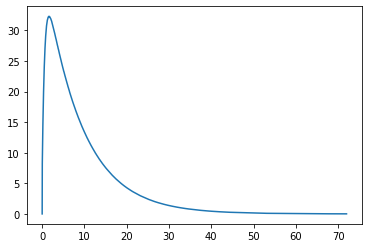

In [47]:
# Best fit function
plot_best_fit(best_result.x,subject_id)

<a name="part4"></a>
### 4 - Generation of Plasma Concentration Trajectory Data with Python

In [52]:
bounds = [(0.0, 0.5), (10.0, 105.0), (0.0, 15.0), (0.0, 40.0)]

# Solve for all subjects
de_results = []
trajectory_data = []

for subject_id in range(1, len(df_pk_paras)+1):
    start = time.perf_counter()
    best_result = differential_evolution(objective_func_pk, bounds, args = (df_pk_paras, subject_id,), maxiter = 15)
    de_results.append([subject_id, best_result.x, best_result.fun])
    output = ode_solver(best_result.x, subject_id)
    trajectory_data.append({subject_id: zip(output.t, output.y[1])}) # Using zip for parallel iteration
    finish = time.perf_counter()
    print(f'{subject_id} DE completed in {round((finish - start),2)} seconds')
    print(best_result.x, best_result.fun)

1 DE completed in 461.85 seconds
[ 0.11824533 97.70583341  9.00928127 21.65848602] 0.0005197487875392527
2 DE completed in 389.99 seconds
[ 0.16094239 41.67218003  3.12980241 27.18858169] 0.0007228034979607739
3 DE completed in 379.51 seconds
[ 0.27110926 95.83373503  2.41496055 34.50794835] 3.166242165493768e-05
4 DE completed in 549.41 seconds
[ 0.14312317 88.12131239 13.6493987  20.58457394] 0.00034336535779335364
5 DE completed in 240.17 seconds
[ 0.09770704 15.98284778  3.90726211 15.31350062] 0.001189060642109817
6 DE completed in 321.91 seconds
[ 0.10992014 97.34114495  9.65273567 20.98655715] 3.4110599208607584e-07
7 DE completed in 451.78 seconds
[ 0.088708   56.58490783 13.98463571 11.70023496] 0.0005311311398462544
8 DE completed in 481.61 seconds
[ 0.17958313 51.5367097  12.2356917  16.26481535] 0.00010505489468896879
9 DE completed in 238.12 seconds
[ 0.1552423  28.76096545  5.84642042 12.13127102] 5.029928080210157e-05
10 DE completed in 265.38 seconds
[ 0.12041843 47.699

In [54]:
print(de_results[15][0],de_results[15][1])

16 [ 0.06562493 66.79340953 13.97448374  9.25240605]


Cmax = 45.75108012437264, Tmax = 2.13, AUC = 797.7363747650122


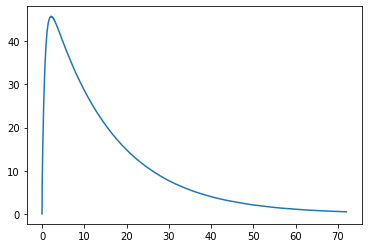

In [55]:
plot_best_fit(de_results[15][1],de_results[15][0])

___
#### Formatting results in dataframe

In [56]:
# Creating dataframe to store results
df_de_results = pd.DataFrame(de_results, columns = ['subject_id', 'k_values','error'])

In [57]:
ka_values = []
k12_values = []
k21_values = []
ke_values = []

In [58]:
for i in range(len(df_de_results)):
    ka_values.append(df_de_results['k_values'].values[i][0])
    k12_values.append(df_de_results['k_values'].values[i][1])
    k21_values.append(df_de_results['k_values'].values[i][2])
    ke_values.append(df_de_results['k_values'].values[i][3])

In [59]:
ke_values

[21.65848601748848,
 27.188581693186073,
 34.50794835195812,
 20.58457393727391,
 15.313500623546354,
 20.9865571490369,
 11.70023495944108,
 16.264815353674642,
 12.131271024688365,
 13.252230731607028,
 13.068382850188161,
 9.219327027390587,
 16.78966533940781,
 18.69677085328157,
 10.439926039985956,
 9.25240605058153,
 7.840375436006561,
 25.333249500152505,
 18.219407930908613,
 29.53881114333276,
 26.656331535323186,
 19.2190236403766,
 10.771793250051367,
 11.942623856065742,
 12.612841646072578,
 8.264297172188622,
 11.537644716444564,
 10.550647029590428,
 11.875728073472104,
 9.78833056830722,
 13.469624307958993,
 8.079431180997805,
 5.516706702119795,
 9.477421416596128,
 6.563451437422482,
 4.136434148120088,
 3.5279377407009482,
 4.145617462102637,
 9.816968892483784,
 8.647548474282708,
 7.7734718788211055,
 9.321528903080143]

In [60]:
df_de_results['ka'] = ka_values
df_de_results['k12'] = k12_values
df_de_results['k21'] = k21_values
df_de_results['ke'] = ke_values

In [61]:
# Display transformed dataframe
df_de_results.head()

,subject_id,k_values,error,ka,k12,k21,ke
0,1,"[0.11824532966897514, 97.7058334113178, 9.0092...",0.000520,0.118245,97.705833,9.009281,21.658486
1,2,"[0.16094239256081797, 41.67218002975715, 3.129...",0.000723,0.160942,41.672180,3.129802,27.188582
2,3,"[0.27110926326268164, 95.83373502567648, 2.414...",0.000032,0.271109,95.833735,2.414961,34.507948
3,4,"[0.14312316736893785, 88.12131238588573, 13.64...",0.000343,0.143123,88.121312,13.649399,20.584574
4,5,"[0.09770704401675906, 15.98284777762263, 3.907...",0.001189,0.097707,15.982848,3.907262,15.313501


In [62]:
# Attaching demographics for each subject
df_de_results = pd.merge(df_de_results, df_attr, on='subject_id')

In [63]:
df_de_results.head()

,subject_id,k_values,error,ka,k12,k21,ke,gender,age_mean,age_sd
0,1,"[0.11824532966897514, 97.7058334113178, 9.0092...",0.000520,0.118245,97.705833,9.009281,21.658486,0,24,4
1,2,"[0.16094239256081797, 41.67218002975715, 3.129...",0.000723,0.160942,41.672180,3.129802,27.188582,0,25,5
2,3,"[0.27110926326268164, 95.83373502567648, 2.414...",0.000032,0.271109,95.833735,2.414961,34.507948,0,25,4
3,4,"[0.14312316736893785, 88.12131238588573, 13.64...",0.000343,0.143123,88.121312,13.649399,20.584574,0,51,8
4,5,"[0.09770704401675906, 15.98284777762263, 3.907...",0.001189,0.097707,15.982848,3.907262,15.313501,0,68,5


In [64]:
# Export df. Bounds = [(0.0, 0.5), (10.0, 105.0), (0.0, 15.0), (0.0, 40.0)], Maxiter = 15
# df_de_results.to_csv('df_de_results_v1.csv', index = False)

___
#### Plotting density plots and histograms of k values

In [66]:
# Import dataframe
df_de_results = pd.read_csv('df_de_results_v1.csv')
df_de_results.head()

,subject_id,k_values,error,ka,k12,k21,ke,gender,age_mean,age_sd
0,1,[ 0.11824533 97.70583341 9.00928127 21.65848602],0.000520,0.118245,97.705833,9.009281,21.658486,0,24,4
1,2,[ 0.16094239 41.67218003 3.12980241 27.18858169],0.000723,0.160942,41.672180,3.129802,27.188582,0,25,5
2,3,[ 0.27110926 95.83373503 2.41496055 34.50794835],0.000032,0.271109,95.833735,2.414961,34.507948,0,25,4
3,4,[ 0.14312317 88.12131239 13.6493987 20.58457394],0.000343,0.143123,88.121312,13.649399,20.584574,0,51,8
4,5,[ 0.09770704 15.98284778 3.90726211 15.31350062],0.001189,0.097707,15.982848,3.907262,15.313501,0,68,5


In [76]:
list_of_cov = [] # List to store coefficient of variation (CoV) across all the k
k_stats = []

In [75]:
# Function to display statistics, density plot and histograms, and to store values
def show_stats(col_name):
    ax = df_de_results[col_name].plot(kind='hist', secondary_y = True)
    df_de_results[col_name].plot.density(bw_method=1); # Orange
    # df_de_results[col_name].plot.density(); # Green line
    mean = df_de_results[col_name].describe()['mean']
    std = df_de_results[col_name].describe()['std']
    cov = std / mean
    list_of_cov.append([col_name, cov])
    k_stats.append([col_name, mean, std])
    print(df_de_results[col_name].describe())
    print('Coefficient of variation = ',cov)

count    42.000000
mean      0.163476
std       0.094684
min       0.054407
25%       0.115533
50%       0.142680
75%       0.175774
max       0.476307
Name: ka, dtype: float64
Coefficient of variation =  0.5791942926802558


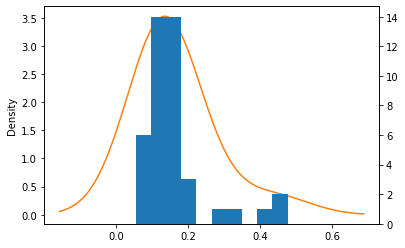

In [81]:
show_stats('ka')

count     42.000000
mean      62.236118
std       27.278174
min       12.519255
25%       41.849712
50%       60.340565
75%       87.357332
max      102.620570
Name: k12, dtype: float64
Coefficient of variation =  0.4383013487476702


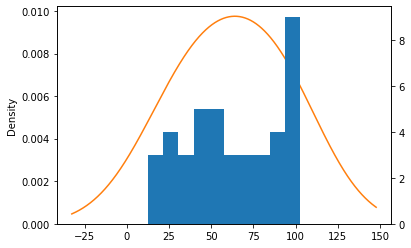

In [70]:
show_stats('k12')

count    42.000000
mean      8.840455
std       3.901086
min       1.337218
25%       6.472237
50%       9.504234
75%      11.973678
max      14.594583
Name: k21, dtype: float64
Coefficient of variation =  0.4412766756921897


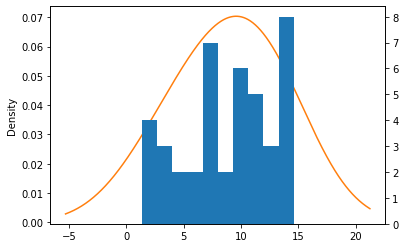

In [82]:
show_stats('k21')

count    42.000000
mean     13.706713
std       7.230307
min       3.527938
25%       9.227597
50%      11.787982
75%      17.861972
max      34.507948
Name: ke, dtype: float64
Coefficient of variation =  0.5275011912949102


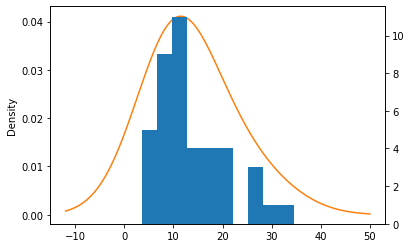

In [72]:
show_stats('ke')

In [73]:
# Display mean and std values
pd.DataFrame(k_stats, columns = ['k','mean','std'])

,k,mean,std
0,ka,0.163476,0.094684
1,k12,62.236118,27.278174
2,k21,8.840455,3.901086
3,ke,13.706713,7.230307


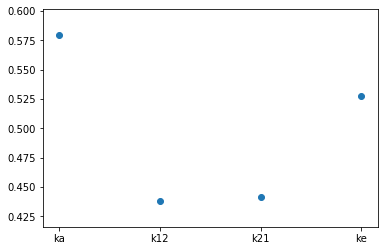

In [74]:
# Comparing coefficient of variations
plt.scatter(*zip(*list_of_cov));

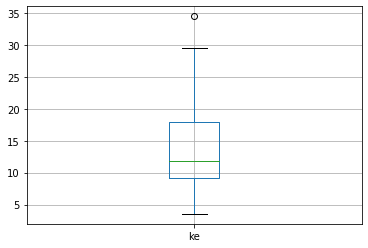

In [64]:
# df_de_results.boxplot(column = ['ka','k12','k21','ke'])
df_de_results.boxplot(column = ['ke'])

#### Generation of Plasma Concentration Trajectory Data with Python

In [76]:
# Recap PK parameters from the literature
list(trajectory_data)

[{1: <zip at 0x23c36527d88>},
 {2: <zip at 0x23c365cd308>},
 {3: <zip at 0x23c364e6a08>},
 {4: <zip at 0x23c36527988>},
 {5: <zip at 0x23c365c7148>},
 {6: <zip at 0x23c365c7648>},
 {7: <zip at 0x23c365cdf88>},
 {8: <zip at 0x23c36519a48>},
 {9: <zip at 0x23c365e3c48>},
 {10: <zip at 0x23c365c7a08>},
 {11: <zip at 0x23c36519708>},
 {12: <zip at 0x23c365d2188>},
 {13: <zip at 0x23c365c7c08>},
 {14: <zip at 0x23c365e3848>},
 {15: <zip at 0x23c365cd748>},
 {16: <zip at 0x23c365c7b08>},
 {17: <zip at 0x23c365e5548>},
 {18: <zip at 0x23c365e5c08>},
 {19: <zip at 0x23c365e5d48>},
 {20: <zip at 0x23c365e3d48>},
 {21: <zip at 0x23c365dbc08>},
 {22: <zip at 0x23c365db0c8>},
 {23: <zip at 0x23c365d7a08>},
 {24: <zip at 0x23c365d7948>},
 {25: <zip at 0x23c365d3b08>},
 {26: <zip at 0x23c365d7c48>},
 {27: <zip at 0x23c365dd908>},
 {28: <zip at 0x23c365d32c8>},
 {29: <zip at 0x23c365dda08>},
 {30: <zip at 0x23c365de6c8>},
 {31: <zip at 0x23c365de2c8>},
 {32: <zip at 0x23c365dbd08>},
 {33: <zip at 0x2

In [80]:
# Export and save the trajectory data in pickle file
with open('trajectory_data_python_v1.pkl', 'wb') as handle:
    pickle.dump(trajectory_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

___
#### Experiment 2

In [51]:
# Import dataframe
df_de_results = pd.read_csv('df_de_results_v1.csv')
df_de_results.sort_values(by=['ka'])

,subject_id,k_values,error,ka,k12,k21,ke,gender,age_mean,age_sd
14,15,[ 0.05440706 47.56046127 13.60442773 10.43992604],4.417594e-03,0.054407,47.560461,13.604428,10.439926,1,40,8
15,16,[ 0.06562493 66.79340953 13.97448374 9.25240605],3.735163e-03,0.065625,66.793410,13.974484,9.252406,1,68,3
13,14,[ 0.07051629 94.41268013 12.11305276 18.69677085],8.318632e-06,0.070516,94.412680,12.113053,18.696771,1,51,4
6,7,[ 0.088708 56.58490783 13.98463571 11.70023496],5.311311e-04,0.088708,56.584908,13.984636,11.700235,0,69,3
39,40,[ 0.08939024 65.02573075 10.82922189 8.64754847],1.874028e-05,0.089390,65.025731,10.829222,8.647548,1,68,3
22,23,[ 0.09405152 87.88765012 10.92485583 10.77179325],2.905354e-05,0.094052,87.887650,10.924856,10.771793,0,69,3
4,5,[ 0.09770704 15.98284778 3.90726211 15.31350062],1.189061e-03,0.097707,15.982848,3.907262,15.313501,0,68,5
38,39,[ 0.09978464 53.7464059 7.6488529 9.81696889],4.186541e-04,0.099785,53.746406,7.648853,9.816969,1,40,8
5,6,[ 0.10992014 97.34114495 9.65273567 20.98655715],3.411060e-07,0.109920,97.341145,9.652736,20.986557,0,33,6
40,41,[ 0.11163854 84.60670096 13.83246397 7.77347188],3.051048e-04,0.111639,84.606701,13.832464,7.773472,1,23,4


In [69]:
# Step 2
# Reviewing anomalies (those with outlier ka and/or ke values)
# Outlier definition not strict: Values below 10 percentile or above 90 percentile
ka_10percentile = df_de_results.ka.quantile(.1)
ka_90percentile = df_de_results.ka.quantile(.9)
ke_10percentile = df_de_results.ke.quantile(.1)
ke_90percentile = df_de_results.ke.quantile(.9)

In [57]:
ke_90percentile

24.965773151886097

In [72]:
outlier_df = df_de_results.loc[(df_de_results['ka'] > ka_90percentile) |
                              (df_de_results['ka'] < ka_10percentile) | 
                              (df_de_results['ke'] > ke_90percentile) |
                              (df_de_results['ke'] < ke_10percentile)]

In [73]:
outlier_df

,subject_id,k_values,error,ka,k12,k21,ke,gender,age_mean,age_sd
1,2,[ 0.16094239 41.67218003 3.12980241 27.18858169],7.228035e-04,0.160942,41.672180,3.129802,27.188582,0,25,5
2,3,[ 0.27110926 95.83373503 2.41496055 34.50794835],3.166242e-05,0.271109,95.833735,2.414961,34.507948,0,25,4
6,7,[ 0.088708 56.58490783 13.98463571 11.70023496],5.311311e-04,0.088708,56.584908,13.984636,11.700235,0,69,3
13,14,[ 0.07051629 94.41268013 12.11305276 18.69677085],8.318632e-06,0.070516,94.412680,12.113053,18.696771,1,51,4
14,15,[ 0.05440706 47.56046127 13.60442773 10.43992604],4.417594e-03,0.054407,47.560461,13.604428,10.439926,1,40,8
15,16,[ 0.06562493 66.79340953 13.97448374 9.25240605],3.735163e-03,0.065625,66.793410,13.974484,9.252406,1,68,3
17,18,[ 0.14831555 102.62056971 8.35665066 25.33...,3.794906e-04,0.148316,102.620570,8.356651,25.333250,0,23,4
19,20,[ 0.33521924 61.01221988 1.80517754 29.53881114],2.257723e-11,0.335219,61.012220,1.805178,29.538811,0,25,4
20,21,[ 0.15339602 97.32858923 4.67257464 26.65633154],1.185675e-04,0.153396,97.328589,4.672575,26.656332,0,32,4
26,27,[ 0.42378836 98.64792314 1.33721849 11.53764472],1.618560e-03,0.423788,98.647923,1.337218,11.537645,0,26,7


In [88]:
# Rerun DE for these outliers, but fixing the k12 and k21 values
# k21: 4.9 to 12.7 (within 1 S.D.), k12: 34.9 to 89.5 (within 1 S.D)
outlier_bounds = [(0.0, 1.0), (34.9, 89.5), (4.9, 12.7),(0.0, 40.0)]

In [83]:
outlier_ids = outlier_df['subject_id'].values
outlier_ids

array([ 2,  3,  7, 14, 15, 16, 18, 20, 21, 27, 33, 35, 36, 37, 38, 40],
      dtype=int64)

In [84]:
outlier_df_paras = df_pk_paras.loc[df_pk_paras['subject_id'].isin(outlier_ids)]

In [85]:
outlier_df_paras

,subject_id,Cmax_mean,Cmax_sd,Tmax_mean,Tmax_sd,AUC_mean,AUC_sd,reference,dosing,dose
1,2,32.5,9.7,1.50,0.60,281,83,21,Single,15
2,3,31.6,12.8,1.82,0.71,216,46,22,Single,15
6,7,48.4,20.1,1.59,0.74,647,294,25,Single,20
13,14,24.7,6.9,1.80,0.80,397,218,23,Single,15
14,15,36.9,11.3,1.72,1.00,673,248,25,Single,20
15,16,45.6,20.2,2.03,1.64,770,270,25,Single,20
17,18,34.2,13.4,1.54,0.51,294,100,30,Multiple,15
19,20,41.8,7.7,1.47,0.75,252,48,22,Multiple,15
20,21,30.6,7.8,2.02,1.11,282,51,32,Multiple,15
26,27,55.0,8.9,2.96,1.24,630,160,34,Multiple,30


In [89]:
# Solve for outlier subjects
outlier_de_results = []
outlier_trajectory_data = []

for subject_id in outlier_ids:
    start = time.perf_counter()
    best_result = differential_evolution(objective_func_pk, outlier_bounds, args = (outlier_df_paras, subject_id,), maxiter = 15)
    outlier_de_results.append([subject_id, best_result.x, best_result.fun])
    output = ode_solver(best_result.x, subject_id)
    outlier_trajectory_data.append({subject_id: zip(output.t, output.y[1])}) # Using zip for parallel iteration
    finish = time.perf_counter()
    print(f'{subject_id} DE completed in {round((finish - start),2)} seconds')
    print(best_result.x, best_result.fun)

2 DE completed in 471.56 seconds
[ 0.14714032 83.66304081  6.95327086 26.60529033] 1.4393078765793696e-05
3 DE completed in 608.87 seconds
[ 0.16803431 88.19539005  5.09873066 31.91199631] 0.01903872057423943
7 DE completed in 340.37 seconds
[ 0.08562202 40.09984851 10.66076803 11.48892336] 0.00015822159025312928
14 DE completed in 518.92 seconds
[ 0.07043079 70.6632604   9.85296831 18.48073205] 0.0005457128409656819
15 DE completed in 606.76 seconds
[ 0.06225341 37.37038666  9.37808037 11.14638523] 0.000493775302871182
16 DE completed in 531.06 seconds
[ 0.06553863 36.82870405  8.39521278  9.51164431] 0.0005702499329806269
18 DE completed in 894.76 seconds
[ 0.15519218 81.15421587  5.88335975 25.70544828] 0.00025618347022973996
20 DE completed in 682.46 seconds
[ 0.23466618 84.94210033  5.23685342 29.08639179] 0.00032347643271919696
21 DE completed in 632.44 seconds
[ 0.1415754  88.48255773  5.18517293 25.88548649] 0.001057129913786433
27 DE completed in 457.57 seconds
[ 0.13108045 81

#### Export Outlier Data to Store first (Not using at this point in time)
To work on these in the future if needed

In [90]:
with open('list_outlier_de_results_v1.pkl', 'wb') as handle:
    pickle.dump(outlier_de_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [91]:
with open('list_outlier_trajectory_data_v1.pkl', 'wb') as handle:
    pickle.dump(outlier_trajectory_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

<a name="part5"></a>
## 5 - Final Optimization

In [1]:
# Import basic dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import time
import pickle

# Import local scikit-pk (skpk) library - https://stackoverflow.com/questions/67631/how-to-import-a-module-given-the-full-path
import sys
sys.path.append(r'C:\Users\klty0\Desktop\scikit-pk\src')
# sys.path.append(r'C:\Users\Kenneth Leung\Desktop\scikit-pk\src')

import skpk

# Import ODE modules
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import differential_evolution

#### Data Preparation
Creating list of lists with elements [subject_id, gender, age mean, age std]  
For gender, 0 = Male and 1 = Female

In [2]:
list_of_attr = [
    [1,0,24,4],
    [2,0,25,5],
    [3,0,25,4], 
    [4,0,51,8], 
    [5,0,68,5], 
    [6,0,33,6], 
    [7,0,69,3], 
    [8,0,21,1], 
    [9,0,23,4], 
    [10,0,27,9], 
    [11,0,28,6], 
    [12,0,22,1], 
    [13,1,23,3], 
    [14,1,51,4], 
    [15,1,40,8], 
    [16,1,68,3], 
    [17,1,23,6],
    [18,0,23,4],
    [19,0,25,4],
    [20,0,25,4],
    [21,0,32,4],
    [22,0,33,6],
    [23,0,69,3],
    [24,0,23,4],
    [25,0,24,4],
    [26,0,25,4],
    [27,0,26,7],
    [28,0,29,7],
    [29,0,30,8],
    [30,0,33,7],
    [31,0,32,4],
    [32,0,23,4],
    [33,0,25,4],
    [34,0,32,4],
    [35,0,23,4],
    [36,0,25,4],
    [37,0,25,4],
    [38,0,23,4],
    [39,1,40,8],
    [40,1,68,3],
    [41,1,23,4],
    [42,1,34,10],
]

In [3]:
df_attr = pd.DataFrame(list_of_attr, columns = ['subject_id','gender','age_mean','age_sd'])

In [4]:
# Create dataframe of PK parameters (Subject ID, Cmax mean, Cmax SD, Tmax mean, Tmax SD, AUC mean, AUC SD, Study Reference)
list_of_pk_paras = [
    [1, 32.3, 11.4, 1.65, 0.70, 345, 103, 20, 'Single', 15],
    [2, 32.5, 9.7, 1.50, 0.60, 281, 83, 21, 'Single', 15],
    [3, 31.6, 12.8, 1.82, 0.71, 216, 46, 22, 'Single', 15],
    [4, 42.5, 16.3, 1.20, 0.30, 362, 66, 23, 'Single', 15],
    [5, 40.6, 13.8, 1.45, 0.73, 486, 161, 24, 'Single', 15],
    [6, 32.1, 8.1, 1.67, 0.65, 355, 199, 25, 'Single', 20],
    [7, 48.4, 20.1, 1.59, 0.74, 647, 294, 25, 'Single', 20],
    [8, 67.7, 20.6, 1.04, 0.10, 459, 136, 26, 'Single', 30],
    [9, 74.4, 23.5, 1.41, 0.74, 614, 177, 27, 'Single', 30],
    [10, 56.1, 13.9, 1.42, 0.56, 562, 134, 28, 'Single', 30],
    [11, 74.5, 37.8, 1.53, 0.78, 570, 137, 29, 'Single', 30],
    [12, 113.0, 55.8, 1.21, 0.40, 808, 285, 26, 'Single', 45],
    [13, 42.0, 8.2, 1.58, 0.68, 445, 94, 21, 'Single', 15],
    [14, 24.7, 6.9, 1.80, 0.80, 397, 218, 23, 'Single', 15],
    [15, 36.9, 11.3, 1.72, 1.00, 673, 248, 25, 'Single', 20],
    [16, 45.6, 20.2, 2.03, 1.64, 770, 270, 25, 'Single', 20],
    [17, 88.8, 38.7, 2.09, 1.84, 950, 298, 29, 'Single', 30],
    [18, 34.2, 13.4, 1.54, 0.51, 294, 100, 30, 'Multiple', 15],
    [19, 39.0, 12.0, 2.20, 1.50, 409, 116, 31, 'Multiple', 15],
    [20, 41.8, 7.7, 1.47, 0.75, 252, 48, 22, 'Multiple', 15],
    [21, 30.6, 7.8, 2.02, 1.11, 282, 51, 32, 'Multiple', 15],
    [22, 45.9, 24.3, 1.33, 0.43, 386, 170, 25, 'Multiple', 20],
    [23, 51.6, 29.4, 2.41, 1.66, 693, 357, 25, 'Multiple', 20],
    [24, 84.2, 36.5, 1.62, 0.82, 618, 205, 30, 'Multiple', 30],
    [25, 76.0, 33.0, 1.99, 1.65, 589, 142, 33, 'Multiple', 30],
    [26, 80.0, 24.0, 2.60, 1.40, 900, 254, 31, 'Multiple', 30],
    [27, 55.0, 8.9, 2.96, 1.24, 630, 160, 34, 'Multiple', 30],
    [28, 80.4, 18.5, 1.10, 0.30, 706, 235, 35, 'Multiple', 30],
    [29, 62.5, 15.8, 2.10, 1.08, 635, 196, 36, 'Multiple', 30],
    [30, 89.0, 21.0, 1.36, 0.39, 761, 140, 37, 'Multiple', 30],
    [31, 63.8, 16.8, 2.08, 0.93, 553, 96, 32, 'Multiple', 30],
    [32, 118.3, 47.3, 1.33, 0.85, 908, 308, 30, 'Multiple', 45],
    [33, 113.0, 29.0, 2.90, 1.80, 1350, 353, 31, 'Multiple', 45],
    [34, 102.1, 37.5, 1.79, 1.03, 786, 176, 32, 'Multiple', 45],
    [35, 141.2, 40.6, 1.06, 0.24, 1135, 247, 30, 'Multiple', 60],
    [36, 158.0, 41.0, 2.70, 1.60, 1793, 447, 31, 'Multiple', 60],
    [37, 181.0, 44.0, 3.10, 1.70, 2149, 476, 31, 'Multiple', 75],
    [38, 227.5, 31.1, 1.67, 0.58, 1797, 446, 30, 'Multiple', 80],
    [39, 59.9, 21.4, 2.33, 1.62, 769, 234, 25, 'Multiple', 20],
    [40, 62.0, 27.6, 2.31, 1.43, 860, 238, 25, 'Multiple', 20],
    [41, 81.7, 26.9, 2.29, 1.03, 958, 272, 34, 'Multiple', 30],
    [42, 80.0, 16.0, 1.39, 0.42, 785, 173, 37, 'Multiple', 30],
]

In [5]:
df_pk_paras = pd.DataFrame(list_of_pk_paras, columns = ['subject_id','Cmax_mean','Cmax_sd','Tmax_mean','Tmax_sd',
                                                        'AUC_mean','AUC_sd','reference','dosing', 'dose'])
df_pk_paras

,subject_id,Cmax_mean,Cmax_sd,Tmax_mean,Tmax_sd,AUC_mean,AUC_sd,reference,dosing,dose
0,1,32.3,11.4,1.65,0.70,345,103,20,Single,15
1,2,32.5,9.7,1.50,0.60,281,83,21,Single,15
2,3,31.6,12.8,1.82,0.71,216,46,22,Single,15
3,4,42.5,16.3,1.20,0.30,362,66,23,Single,15
4,5,40.6,13.8,1.45,0.73,486,161,24,Single,15
5,6,32.1,8.1,1.67,0.65,355,199,25,Single,20
6,7,48.4,20.1,1.59,0.74,647,294,25,Single,20
7,8,67.7,20.6,1.04,0.10,459,136,26,Single,30
8,9,74.4,23.5,1.41,0.74,614,177,27,Single,30
9,10,56.1,13.9,1.42,0.56,562,134,28,Single,30


#### Setup skpk Model instance

In [6]:
C0 = skpk.Cmt(0, 'Absorption (GI Tract)')
C1 = skpk.Cmt(1, 'Central')
C2 = skpk.Cmt(2, 'Peripheral')
C3 = skpk.Cmt(3, 'External / Elimination')
pk_model = skpk.Model('PK Model - Mirtazapine')

0-Absorption (GI Tract) compartment successfully generated
1-Central compartment successfully generated
2-Peripheral compartment successfully generated
3-External / Elimination compartment successfully generated
 Model named PK Model - Mirtazapine successfully generated


#### Read in trajectory data

In [7]:
# Reading pickle file (stored trajectory data) generated from Python DE earlier
with open('trajectory_data_python_v1.pkl', 'rb') as handle:
    raw_trajectory_data = pickle.load(handle)

In [8]:
trajectories = list(raw_trajectory_data)
trajectories

[{1: <zip at 0x2a5c6829f88>},
 {2: <zip at 0x2a5c682b8c8>},
 {3: <zip at 0x2a5c6829488>},
 {4: <zip at 0x2a5c6829708>},
 {5: <zip at 0x2a5c6829a08>},
 {6: <zip at 0x2a5c6829c48>},
 {7: <zip at 0x2a5c685afc8>},
 {8: <zip at 0x2a5c685a548>},
 {9: <zip at 0x2a5c685aec8>},
 {10: <zip at 0x2a5c682b2c8>},
 {11: <zip at 0x2a5c685a788>},
 {12: <zip at 0x2a5c685aa48>},
 {13: <zip at 0x2a5c3108908>},
 {14: <zip at 0x2a5c3108308>},
 {15: <zip at 0x2a5c682e9c8>},
 {16: <zip at 0x2a5c682e888>},
 {17: <zip at 0x2a5c682e048>},
 {18: <zip at 0x2a5c682e748>},
 {19: <zip at 0x2a5c682e448>},
 {20: <zip at 0x2a5c682e8c8>},
 {21: <zip at 0x2a5c686dec8>},
 {22: <zip at 0x2a5c206b0c8>},
 {23: <zip at 0x2a5c6826548>},
 {24: <zip at 0x2a5c6868288>},
 {25: <zip at 0x2a5c6866308>},
 {26: <zip at 0x2a5c686da88>},
 {27: <zip at 0x2a5c686ddc8>},
 {28: <zip at 0x2a5c6839348>},
 {29: <zip at 0x2a5c6839208>},
 {30: <zip at 0x2a5c6839c88>},
 {31: <zip at 0x2a5c6839788>},
 {32: <zip at 0x2a5c6839748>},
 {33: <zip at 0x2

In [9]:
# Unpacking the concentration time trajectory data for each subject
list_subject_data = []

for i in range(1,len(trajectories)+1):
    data = trajectories[i-1][i]
    time_x, conc_y = zip(*data)
    subject_df = pd.DataFrame({'time':time_x,
                                'conc':conc_y})
    list_subject_data.append(subject_df)

In [10]:
list_subject_data[0].head(60)

,time,conc
0,0.00,0.000000
1,0.03,7.911438
2,0.07,9.959780
3,0.10,11.303240
4,0.13,12.575035
5,0.17,14.198751
6,0.20,15.338160
7,0.23,16.414361
8,0.27,17.735103
9,0.30,18.708294


In [11]:
# Obtain 18 sample points from each trajectory
sampling_timepoints = [0.00, 0.23, 0.50, 0.77, 1.00, 
                       1.23, 1.50, 1.83, 2.00, 3.00, 
                       4.00, 6.00, 8.00, 11.01, 15.01, 
                       20.01, 24.01, 36.02]

#### Generate sample data points from trajectory data

In [12]:
list_of_samples = []

for df in list_subject_data:
    sample_df = df.loc[df['time'].isin(sampling_timepoints)]
    sample_df.reset_index(drop=True, inplace=True)
    list_of_samples.append(sample_df)

In [13]:
list_of_samples[2]

,time,conc
0,0.00,0.000000
1,0.23,19.909697
2,0.50,24.157950
3,0.77,27.190423
4,1.00,29.106653
5,1.23,30.372336
6,1.50,31.197108
7,1.83,31.600773
8,2.00,31.492007
9,3.00,28.993017


#### Setup PK model

In [14]:
# Instantiate the 3 relevant compartment instances of the 2-compartment model
C0 = skpk.Cmt(0, 'Absorption (GI Tract)')
C1 = skpk.Cmt(1, 'Central')
C2 = skpk.Cmt(2, 'Peripheral')
C3 = skpk.Cmt(3, 'External / Elimination')

pkmodel = skpk.Model('PK Model - Mirtazapine')
pkmodel.add_cmt([C0, C1, C2, C3])

0-Absorption (GI Tract) compartment successfully generated
1-Central compartment successfully generated
2-Peripheral compartment successfully generated
3-External / Elimination compartment successfully generated
 Model named PK Model - Mirtazapine successfully generated


#### Functions for optimization

In [15]:
# Pre-defined parameters
F = 0.497 # Bioavailability
n = 3 # Number of compartments (+1 for GI tract compartment for oral route)

period_start = 0
period_end = 72
intervals = 2160
time_horizon = np.around(np.linspace(period_start, period_end, intervals), decimals=2)

In [16]:
# Define dcdt function of ODE (dot multiplication of coefficient matrix and concentration)
def dC(t,C,A):
   
    # Dot multiplication of A coefficient matrix (n x n) with concentration vector C (n x 1) 
    dCdt = np.dot(A, C)
    
    # Returns dCdt as n x 1 vector (dC0/dt, dC1/dt, dC2/dt)
    return dCdt

In [17]:
# Create function that generates coefficient matrix and runs solve_ivp
def ode_solver(p, subject_id):
    
    ka, k12, k21, ke = p    
       
    # Add links based on parameters (p) passed as arguments
    pk_model.add_link([(C0, C1, ka), (C1, C2, k12), (C2, C1, k21), (C1, C3, ke)])
    full_matrix = pk_model.get_matrix()
    
    # Ignoring elimination compartment (C3), so we truncate matrix size by 1 to form coefficient matrix (n is exclusive)
    A_matrix = full_matrix[0:n,0:n]

    # Initial concentration
    dose_mg = df_pk_paras[df_pk_paras.subject_id == 1]['dose'][0]
    
    # Convert dose from mg to ug
    dose_ug = dose_mg * 1000
    
    C_initial = np.zeros(n)
    C_initial[0] = dose_ug * F # C0 in GI tract compartment, and taking bioavailability into account
    
    # Reshaping C_initial into 1 dimension to pass into solve_ivp
    C_initial_1dim = C_initial.reshape(n,)

    # Solving ODE
    output = solve_ivp(fun=dC, t_span=[period_start, period_end], y0 = C_initial_1dim, t_eval = time_horizon, args=(A_matrix,))
    
    return output

In [18]:
# Objective function (for optimization using sampled data points)
def objective_func_sample_data(p, subject_id):
    
    # Obtaining ODE output after solving
    output = ode_solver(p, subject_id)

    # Get ODE-predicted plasma concentration of central compartment
    sample_df = list_of_samples[subject_id - 1]
    output_dict = dict(zip(output.t, output.y[1])) # Combining time (x-axis) with conc (y-axis) together as dict
    t_sample = sample_df['time'].values
    y_pred = [output_dict[x] for x in t_sample] # Obtaining predicted conc values based on time intervals from sample data
    y_actual = sample_df['conc'].values
      
    # Calculate RMSE
    error = y_actual - y_pred
    # normalized_error = error / y_actual.max() # Use this if intend to calculate normalized RMSE
    squared_error = np.power(error,2)
    sum_error = np.sum(squared_error)
    mse = sum_error / y_actual.shape[0]
    rmse = np.sqrt(mse)
    return rmse

In [19]:
# Plot best fit from best results (differential evolution)
def plot_best_fit(p, subject_id):
       
    output = ode_solver(p, subject_id)
    plt.plot(output.t,output.y[1])
    plt.scatter(list_of_samples[subject_id-1]['time'], list_of_samples[subject_id-1]['conc'])

In [20]:
bounds = [(0.0, 1.0), (30.0, 90.0), (0.0, 15.0),(0.0, 35.0)]

In [267]:
# Solve for several subjects (Pre-test)
de_results = []

# Small test
for subject_id in range(1, 3):
    start = time.perf_counter()
    best_result = differential_evolution(objective_func_sample_data, bounds, args = (subject_id,), maxiter = 15)
    de_results.append([subject_id, best_result.x, best_result.fun])
    finish = time.perf_counter()
    print(f'{subject_id} DE completed in {round((finish - start),2)} seconds')
    print(best_result.x, best_result.fun)

1 DE completed in 426.22 seconds
[ 0.11857604 87.81349864  8.02013887 21.64401576] 0.06720966770661939
2 DE completed in 517.79 seconds
[ 0.15626852 41.63411136  3.35413202 26.79836069] 0.11487597738841306


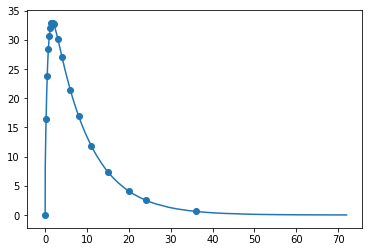

In [275]:
plot_best_fit(de_results[0][1],1) # Get first row (index 0), and access best k values (p), subject_id)

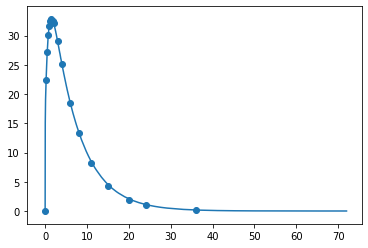

In [276]:
plot_best_fit(de_results[1][1],2) # Get first row (index 0), and access best k values (p), subject_id)

In [22]:
# Run for all 42 subjects
de_results = []

for subject_id in range(1, len(list_of_samples)+1):
    
    start = time.perf_counter()
    best_result = differential_evolution(objective_func_sample_data, bounds, args = (subject_id,), maxiter = 15)
    de_results.append([subject_id, best_result.x, best_result.fun])
    
    finish = time.perf_counter()
    print(f'{subject_id} DE completed in {round((finish - start),2)} seconds')
    print(best_result.x, best_result.fun)

1 DE completed in 339.0 seconds
[ 0.11855455 86.88854404  7.93105446 21.64605987] 0.0736389835268978
2 DE completed in 385.14 seconds
[ 0.16091617 41.9550426   3.15702188 27.19370003] 0.015310568574437577
3 DE completed in 443.37 seconds
[ 0.2554712  86.95186462  2.42230065 34.05522235] 0.125844944752329
4 DE completed in 411.8 seconds
[ 0.14370981 68.78313556 10.49855444 20.57786347] 0.13820824098230708
5 DE completed in 374.81 seconds
[ 0.09426647 40.24914018 11.85330042 15.22203955] 0.8322269818762066
6 DE completed in 922.05 seconds
[ 0.11016399 86.32440095  8.4907361  20.97343378] 0.07066738736879913
7 DE completed in 357.96 seconds
[ 0.08861838 54.74502044 13.52132798 11.68237409] 0.03136800924692328
8 DE completed in 328.71 seconds
[ 0.18011155 41.53178267  9.76638541 16.25292568] 0.20170077964759722
9 DE completed in 365.09 seconds
[ 0.60935356 86.69021623  1.68284139 12.99147985] 3.191252688591597
10 DE completed in 386.67 seconds
[ 0.12066658 43.05487264  8.53496339 13.241833

In [ ]:
# TO DO
# Think about whether bioavailability is incorporated correctly
# Think about what are the units for the k (1^-2mins?)